In [1]:
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import numpy as np
import re
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [72]:
training_doc3 = "How are you? How many days since we last met? How are your parents?"

## Text Preprocessing

In [73]:
cleaned = re.sub(r'\W+', ' ', training_doc3).lower()
tokens = word_tokenize(cleaned)
print(len(tokens))
#print(tokens)
# Next we'll create sequences taking 4 cosequtive tokens at a time
train_len = 4
text_sequences = []
pos = 0
items = train_len
for i in range(train_len,len(tokens)+1):
  text_sequences.append(tokens[pos:items])
  pos+=1
  items+=1
print(text_sequences)

14
[['how', 'are', 'you', 'how'], ['are', 'you', 'how', 'many'], ['you', 'how', 'many', 'days'], ['how', 'many', 'days', 'since'], ['many', 'days', 'since', 'we'], ['days', 'since', 'we', 'last'], ['since', 'we', 'last', 'met'], ['we', 'last', 'met', 'how'], ['last', 'met', 'how', 'are'], ['met', 'how', 'are', 'your'], ['how', 'are', 'your', 'parents']]


In [75]:
# let's create sequences with the obtained integer values for each unique token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)
print(sequences)
print(tokenizer.word_index) # to check how the unique tokens have been mapped in our sequences

[[1, 2, 9, 1], [2, 9, 1, 3], [9, 1, 3, 4], [1, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 1], [7, 8, 1, 2], [8, 1, 2, 10], [1, 2, 10, 11]]
{'how': 1, 'are': 2, 'many': 3, 'days': 4, 'since': 5, 'we': 6, 'last': 7, 'met': 8, 'you': 9, 'your': 10, 'parents': 11}


In [76]:
target = []
sequence_list = []
for i in sequences:
  #print(i)
  sequence_list.append(i[:-1])
  target.append(i[-1])
  
print(sequences)
print(sequence_list,target)

[[1, 2, 9, 1], [2, 9, 1, 3], [9, 1, 3, 4], [1, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 1], [7, 8, 1, 2], [8, 1, 2, 10], [1, 2, 10, 11]]
[[1, 2, 9], [2, 9, 1], [9, 1, 3], [1, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 1], [8, 1, 2], [1, 2, 10]] [1, 3, 4, 5, 6, 7, 8, 1, 2, 10, 11]


## Crate Training inputs & Training labels

In [77]:
ohe = OneHotEncoder(sparse = False)
targets = np.array(target).reshape(-1,1)
targets = ohe.fit_transform(targets)
train_targets = np.concatenate((np.zeros((targets.shape[0],1)),targets),axis = 1) # adding a zero to match target
print(train_targets)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [78]:
train_inputs = np.array(sequence_list)
print(train_inputs)

[[ 1  2  9]
 [ 2  9  1]
 [ 9  1  3]
 [ 1  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  1]
 [ 8  1  2]
 [ 1  2 10]]


## Build & Train the Model

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense

vocabulary_size = len(tokenizer.word_index)
embedding_dim = 6 #train_inputs.shape[0]
max_length = train_inputs.shape[1]



model = Sequential()
model.add(Embedding(input_dim = vocabulary_size, output_dim = embedding_dim, input_length = max_length))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
# compiling the network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(train_inputs,train_targets,epochs=120,verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 3, 6)              66        
_________________________________________________________________
lstm_34 (LSTM)               (None, 3, 50)             11400     
_________________________________________________________________
lstm_35 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 11)                561       
Total params: 34,777
Trainable params: 34,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1/1 [==============================] - 4s 4s/step - loss: 2.3979 - accuracy: 0.0000e+00
Epoch 2/120
1/1

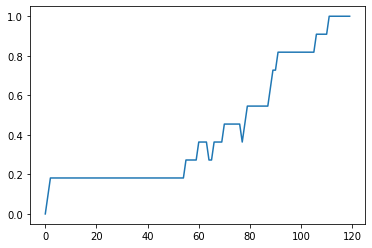

In [95]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])

## Predicting the next word (3 most probable)

In [127]:
from keras.preprocessing.sequence import pad_sequences

input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=max_length, truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0].argsort()[::-1][:3]):
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)

how many days
[1, 3, 4] [[1 3 4]]
Next word suggestion: since
Next word suggestion: many
Next word suggestion: how
